In [1]:
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

In [2]:
DATA_DIR = './dataset'

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
X_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
y_train = train_df['label']
X_train = train_df.drop('label', axis=1)

In [5]:
X_draft_train, X_val, y_draft_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [6]:
def replace_none_nan_by_np_nan(df):
    return df.replace({
        'None': np.nan,
        'nan': np.nan,
        True: 1,
        False: 0
    })

In [7]:
def gini_score(y_pred_proba, y_truth):
    return (2 * roc_auc_score(y_truth, y_pred_proba[:,1])) - 1

In [8]:
bhyt = ['DK', 'CT', 'XN', 'XK', 'NO', 'TE', 'SV', 'GB', 'TA', 'PV', 'CN', 'CH', 'TB', 'GD', 'CB', 'KC', 'TC', 'HT', 'CS', 'CK', 'HS', 'TY', 'DN', 'TN', 'MS', 'TS', 'LS', 'XB', 'HG', 'TK', 'TQ', 'TV', 'HC', 'CY', 'DT', 'NN', 'CA', 'CC', 'QN', 'BT', 'XD', 'HN', 'HX', 'HD', 'UNK']
BHYT_encoder = OneHotEncoder()
BHYT_encoder.fit(np.array(bhyt).reshape(-1, 1))
def clean_bhyt(df):
    df[~df.isin(bhyt)] = 'UNK'
    return BHYT_encoder.transform(df)
# clean_bhyt(clean_df)

In [9]:
KV_FIXED = np.array(['K1', 'K2', 'K3', 'UNK'])
KV_encoder = OneHotEncoder()
KV_encoder.fit(KV_FIXED.reshape(-1, 1))
def kv_to_int(df: pd.DataFrame):
    df[~df.isin(KV_FIXED)] = 'UNK'
    return KV_encoder.transform(df)

In [10]:
def true_false_to_int(x: str):
    if isinstance(x, str):
        x = x.lower()
        if x in ['true', 'false']:
            return 1 if x == 'true' else 0
    elif x in [True, False]:
        return 1 if x else 0
    else:
        return np.nan

def convert_true_false_to_0_1(df):
    for col in df.columns:
        df[col] = df[col].apply(true_false_to_int)
    return df

In [11]:
def clean_value_field_45(x: str):
    if isinstance(x, str):
        return x
    else:
        try:
            return str(int(x))
        except ValueError:
            return np.nan

def clean_field_45(df):
    df[df.columns[0]] = df[df.columns[0]].apply(clean_value_field_45)
    return df

In [12]:
# 26 35: co the consider nan = 1 class
# 

In [13]:
sr = pd.Series()

30000
3
0.3226
False    12301
NaN       9678
True      8021
Name: FIELD_26, dtype: int64


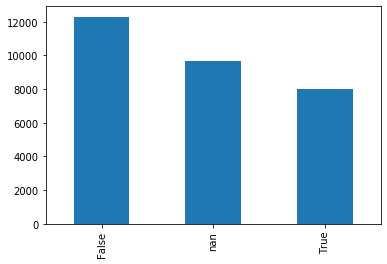

In [14]:
# [26,34,46,47]
field = 'FIELD_26'
# print(train_df[field].unique())
print(len(train_df[field]))
print(len(train_df[field].unique()))
print(train_df[field].isna().sum() / len(train_df[field].isna()))
# (train_df[field].fillna('aa').hist())
# (train_df[field].hist())
# (train_df[field].fillna(0).astype(np.uint8).hist())
# (train_df[field].fillna(-1).astype(np.int64).value_counts().plot(kind='bar'))
print(train_df[field].value_counts(dropna=False))
(train_df[field].value_counts(dropna=False).plot(kind='bar'))

In [15]:
class TopCountrySelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_top=4):
        self.num_top = num_top
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        assert isinstance(X, pd.Series) or X.shape[1] == 1
        if isinstance(X, pd.DataFrame) and X.shape[1]== 1:
            X = X.loc[:, X.columns[0]]
        top = X.value_counts()[:min(self.num_top, len(X))]
        X[~X.isin(top)] = 'OTHER'
        return pd.DataFrame(X)

In [16]:
def clean_text(df):
    def _clean(s: str):
        return re.sub(r'[\d()_+?!]+', '', re.sub(r'[^(?u)\w+]', '', s))

    for column in df.columns:
        df[column] = df[column].apply(_clean)
    return df.iloc[:, 0]

In [17]:
def nan_to_none_str(df):
    assert df.shape[1] == 1
    return df.iloc[:, 0].fillna('None') # must return series

In [18]:
# TODO: 39 - country
# TODO: I dropped 40!
# TODO: field 41 ,45 test has more categories!!
# 52 53 54 56 57 most
# 55 na qua nhieu -> drop
# TODO: FIELD_35 should be ordered
def create_pipeline():
#     true_false_columns = ['FIELD_23', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_42', 'FIELD_47', 'FIELD_48', 'FIELD_49']
#     true_false_columns += [f'FIELD_{i}' for i in [14,15,18,19,20]]
#     true_false_columns += [f'FIELD_{i}' for i in range(25,35)]
    
    full_pipeline = make_pipeline(
        make_column_transformer(
            (make_pipeline(
                FunctionTransformer(nan_to_none_str, validate=False),
                CountVectorizer(decode_error='ignore', ngram_range=(2,3)),
                TfidfTransformer(),
                KMeans(n_clusters=5, n_jobs=2),
            ), ['maCv']),
            (make_pipeline(
                TopCountrySelector(num_top=4),
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), ['FIELD_39']),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [8,14,15,17,18,19,20,21,24,25,27,28,29,30,31,32,33,38,41,42,43,44,48,49] + [26,34,46,47]]),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=False),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [23]]),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='UNK'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ),  ['province', 'district', 'FIELD_35']),
            (make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='median'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [34,46,47]]),
            (make_pipeline(
                FunctionTransformer(convert_true_false_to_0_1, validate=False),
                SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=2),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [26]]),
            (make_pipeline(
                FunctionTransformer(convert_true_false_to_0_1, validate=False),
                SimpleImputer(missing_values=np.nan, strategy='median'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), [f'FIELD_{i}' for i in [26, 36, 37]]),
            (make_pipeline(
                FunctionTransformer(clean_field_45, validate=False),
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')
            ), ['FIELD_45']),
            (SimpleImputer(missing_values=np.nan, strategy='median'), ['age_source1', 'age_source2']),
            (SimpleImputer(missing_values=np.nan, strategy='most_frequent'), [f'FIELD_{i}' for i in [16,52,53,54,56,57]]),
        ),
        StandardScaler(with_mean=False),
#         TruncatedSVD(n_components=500, n_iter=7, random_state=0),
        MLPClassifier(hidden_layer_sizes=(100,), solver='lbfgs', random_state=0)
#         LogisticRegression(solver='lbfgs', n_jobs=2) #class_weight='balanced', 
    )
    return full_pipeline
full_pipeline = create_pipeline()

# Huan luyen va validate

In [19]:
full_pipeline.fit(X_draft_train, y_draft_train)
y_pred = full_pipeline.predict(X_val)
print('Full training set accuracy:', accuracy_score(y_val, y_pred))
y_pred_proba = full_pipeline.predict_proba(X_val)
print('Full training set GINI Score:', gini_score(y_pred_proba, y_val))

Full training set accuracy: 0.9828333333333333
Full training set GINI Score: 0.11311819402317136


# Find best params

In [20]:
full_pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                     transformer_weights=None,
                     transformers=[('pipeline-1',
                                    Pipeline(memory=None,
                                             steps=[('functiontransformer',
                                                     FunctionTransformer(accept_sparse=False,
                                                                         check_inverse=True,
                                                                         func=<function nan_to_none_str at 0x7f247e533050>,
                                                                         inv_kw_args=None,
                                                                         inverse_func=None,
                                                                         kw_args=None,
                                                                

In [21]:
alphas = [0, 0.1, 10, 100, 0.01]
top_countries = [1,3,5,7]
k_clusters_job = [3,5,7]

results = []

params = [
    {
        'columntransformer__pipeline-1__kmeans__n_clusters': k_cluster,
        'columntransformer__pipeline-2__topcountryselector__num_top': top_country,
    }
#         'mlpclassifier__alpha': alpha,
#     } for alpha in alphas
        for top_country in top_countries
        for k_cluster in k_clusters_job
]

total = len(params)
print('Start')
for index, param in enumerate(params):
    print(f'{index}/{total}')
    print('Current param:')
    print(param)
    full_pipeline.set_params(**param)
    full_pipeline.fit(X_draft_train, y_draft_train)

#     train_loss = full_pipeline['mlpclassifier'].loss_
#     train_loss = full_pipeline['logisticregression'].loss_
    train_acc = full_pipeline.score(X_draft_train, y_draft_train)

    y_pred = full_pipeline.predict(X_val)
    y_pred_proba = full_pipeline.predict_proba(X_val)
    val_acc = accuracy_score(y_val, y_pred)
    val_gini = gini_score(y_pred_proba, y_val)

    result = {
#         'train_loss': train_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_gini': val_gini,
        'params': param
    }
    results.append(result)

#     print(f'\tTrainLoss: {train_loss:2.4f}\tTrainAcc: {train_acc:2.4f}\tValAcc: {val_acc:2.4f}\tGINIScore: {val_gini:2.4f}')
    print(f'\tTrainAcc: {train_acc:2.4f}\tValAcc: {val_acc:2.4f}\tGINIScore: {val_gini:2.4f}')

'Done'

Start
0/12
Current param:
{'columntransformer__pipeline-1__kmeans__n_clusters': 3, 'columntransformer__pipeline-2__topcountryselector__num_top': 1}
	TrainAcc: 0.9878	ValAcc: 0.9808	GINIScore: 0.0691
1/12
Current param:
{'columntransformer__pipeline-1__kmeans__n_clusters': 5, 'columntransformer__pipeline-2__topcountryselector__num_top': 1}
	TrainAcc: 0.9889	ValAcc: 0.9817	GINIScore: 0.1359
2/12
Current param:
{'columntransformer__pipeline-1__kmeans__n_clusters': 7, 'columntransformer__pipeline-2__topcountryselector__num_top': 1}
	TrainAcc: 0.9879	ValAcc: 0.9815	GINIScore: 0.1454
3/12
Current param:
{'columntransformer__pipeline-1__kmeans__n_clusters': 3, 'columntransformer__pipeline-2__topcountryselector__num_top': 3}
	TrainAcc: 0.9878	ValAcc: 0.9812	GINIScore: 0.1459
4/12
Current param:
{'columntransformer__pipeline-1__kmeans__n_clusters': 5, 'columntransformer__pipeline-2__topcountryselector__num_top': 3}
	TrainAcc: 0.9882	ValAcc: 0.9810	GINIScore: 0.1286
5/12
Current param:
{'columnt

'Done'

In [22]:
best_index=3
print('Best index: {}'.format(best_index))
best_params = results[best_index]['params']
print('Best params')
print(best_params)
full_pipeline.set_params(**best_params)
full_pipeline.fit(X_train, y_train)

Best index: 3
Best params
{'columntransformer__pipeline-1__kmeans__n_clusters': 3, 'columntransformer__pipeline-2__topcountryselector__num_top': 3}


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('functiontransformer',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function nan_to_none_str at 0x7f247e533050>,
                                                                                       inv_kw_args=None,
                                                                        

In [23]:
y_pred = full_pipeline.predict(X_train)
print('Full training set accuracy:', accuracy_score(y_train, y_pred))
y_pred_proba = full_pipeline.predict_proba(X_train)
print('Full training set GINI Score:', gini_score(y_pred_proba, y_train))

Full training set accuracy: 0.9873333333333333
Full training set GINI Score: 0.7973022358643498


# Real test!

In [24]:
y_pred = full_pipeline.predict_proba(X_test)

In [25]:
result = pd.DataFrame({
    'id': X_test['id'],
    'label': y_pred[:, 1]
})

In [26]:
print(result)

          id         label
0      30000  1.790841e-02
1      30001  1.790841e-02
2      30002  1.107880e-05
3      30003  9.565372e-03
4      30004  1.790841e-02
...      ...           ...
19995  49995  1.090147e-04
19996  49996  1.274323e-02
19997  49997  1.790841e-02
19998  49998  2.062317e-09
19999  49999  6.268761e-03

[20000 rows x 2 columns]


In [27]:
result.to_csv('submission.csv', index=False)